# Free production data analyses

This notebook performs the following analysis steps:
* Data importing, preprocessing & cleaning
* Find out which rating scale works out for which model
    * Aggregating data by phenomenon, by model, by scale on weighted score of target option
    * Generate a plot accordingly
    * Subset the data for further analysis by choosing scales that lead to best results respectively
* transforming raw metrics into probabilities by item by metric
    * this requires working by-phenomenon, because there are different numbers of options in the different phenomena
* combining this data into one cleaned data file with binarized options (probabilities of target vs rest)
    * long formatting of options and of metrics
* averaging probabilities across items and across seeds, by metric, by model, by phenomenon, by label type
* plotting results by metric, by phenomenon, by model, by label type

In [10]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Import & preprocess the data set

In [52]:
def read_csv_auto_detect_delimiter(file_path):
    # Open the file and read the first line to detect the delimiter
    with open(file_path, 'r', encoding='utf-8') as file:
        first_line = file.readline()
        delimiter = ';' if ';' in first_line else ','
    
    # Read the file into a DataFrame based on the detected delimiter
    df = pd.read_csv(file_path, delimiter=delimiter, engine='python', on_bad_lines='skip')
    
    return df

In [53]:
# Define the path to the 'free' subfolder
free_folder_path = "../results/free"

# Recursively list all csv files in the 'free' folder
csv_files = []
for root, dirs, files in os.walk(free_folder_path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

# Split the csv files into annotated and non-annotated lists
annotated_files = [file for file in csv_files if "_annotated" in file]
non_annotated_files = [file for file in csv_files if "_annotated" not in file]

# Concatenate all annotated csv files into a single dataframe
dataframes = [read_csv_auto_detect_delimiter(file) for file in annotated_files]

# Concatenate all DataFrames together
df_annotated = pd.concat(dataframes, ignore_index=True)
# Return the first few rows of the concatenated dataframe and the number of non-annotated files
df_annotated.head(), len(non_annotated_files)


(                 model_name  temperature phenomenon decoding_scheme question  \
 0  meta-llama/Llama-2-7b-hf          0.9      irony          greedy      NaN   
 1  meta-llama/Llama-2-7b-hf          0.9      irony          greedy      NaN   
 2  meta-llama/Llama-2-7b-hf          0.9      irony          greedy      NaN   
 3  meta-llama/Llama-2-7b-hf          0.9      irony          greedy      NaN   
 4  meta-llama/Llama-2-7b-hf          0.9      irony          greedy      NaN   
 
    seed  item_id                                             prompt  \
 0     3        1  You will read a short story that describes an ...   
 1     3        2  You will read a short story that describes an ...   
 2     3        3  You will read a short story that describes an ...   
 3     3        4  You will read a short story that describes an ...   
 4     3        5  You will read a short story that describes an ...   
 
                                             response response_option  ...  \


In [54]:
# Check for NA values in the 'response_option' column

def compute_na_percentage(df, column_name):
    """
    Compute the count and percentage of NA values for a specified column in the DataFrame.

    Parameters:
    - df: DataFrame
    - column_name: Name of the column for which to compute the NA values.

    Returns:
    - Tuple containing the count and percentage of NA values.
    """
    na_count = df[column_name].isna().sum()
    na_percentage = (na_count / len(df)) * 100
    return f"There are {na_count} NA values in the '{column_name}' column, which is {na_percentage:.2f}% of the total entries."

# Check for NA values in the 'response_option' column before dropping the rows with NA values
print(compute_na_percentage(df_annotated, 'response_option'))



There are 846 NA values in the 'response_option' column, which is 12.54% of the total entries.


In [55]:
# Drop the rows with NA values in the 'response_option' column
df_annotated.loc[df_annotated['response_option'].isna(), 'response_option'] = df_annotated['annotation_tsvilodub']
df_annotated.loc[df_annotated['response_option'].isna(), 'response_option'] = df_annotated['annotation_wang']

# Check for NA values in the 'response_option' column after dropping the rows with NA values
print(compute_na_percentage(df_annotated, 'response_option'))

There are 1 NA values in the 'response_option' column, which is 0.01% of the total entries.


In [56]:
# Extract rows where 'response_option' is NA
na_response_option_rows = df_annotated[df_annotated['response_option'].isna()]

print('Display the rows with NA values in response_option')
print(na_response_option_rows)

# Drop rows with NA values in the 'response_option' column
df_annotated = df_annotated.dropna(subset=['response_option'])

# Confirm the operation by checking the NA percentage for 'response_option' column after dropping
compute_na_percentage(df_annotated, 'response_option')



Display the rows with NA values in response_option
                  model_name  temperature phenomenon decoding_scheme question  \
4523  gpt-3.5-turbo-instruct          0.9     humour          greedy      NaN   

      seed  item_id                                             prompt  \
4523     0       10  You will read a joke that is missing its punch...   

                                               response response_option  ...  \
4523  \n"Actually, I don't want your fortune. I just...             NaN  ...   

     distractor_literal distractor_nonsequitut  \
4523                NaN                    NaN   

           incorrect_straightforward            associative_nonsequitur  \
4523  "Thank you, I need the money."  "I usually get seasick on boats."   

                                      funny_nonsequitur  \
4523  "My pleasure," he said as he tipped his hat to...   

                         neutral_nonsequitur incorrect_lexical_overlap  \
4523  "I hope it's time to eat 

"There are 0 NA values in the 'response_option' column, which is 0.00% of the total entries."

In [57]:
# Check the number of unique values in the 'response_option' column
unique_response_options = df_annotated['response_option'].unique()

# Convert the 'response_option' column to a categorical (factor) type
df_annotated['response_option'] = df_annotated['response_option'].astype('category')

len(unique_response_options), unique_response_options


(22,
 array(['error', 'target', 'competitor', 'distractor_associate',
        'distractor_associative', 'distractor_literal',
        'distractor_plausibleliteral', 'incorrect_associate',
        'incorrect_nonliteral', 'incorrect_social_convention',
        'incorrect_lexical_overlap', 'distractor_nonsequitur',
        'incorrect_literal', 'distractor_lexical_overlap',
        'neutral_nonsequitur', 'incorrect_straightforward',
        'funny_nonsequitur', 'distractor_nonsequitut',
        'associative_nonsequitur', 'funny_nonsequitor',
        'dalwaystractor_lsheeral', 'distractor_plausiliteral'],
       dtype=object))

In [58]:
# Replace the specified values in the 'response_option' column
df_annotated['response_option'] = df_annotated['response_option'].replace({
    'distractor_nonsequitut': 'distractor_nonsequitur',
    'distractor_associate': 'distractor_associative'
})

# Verify the replacement by checking the unique values again
unique_response_options_after_replacement = df_annotated['response_option'].unique()
unique_response_options_after_replacement


['error', 'target', 'competitor', 'distractor_associative', 'distractor_literal', ..., 'funny_nonsequitur', 'associative_nonsequitur', 'funny_nonsequitor', 'dalwaystractor_lsheeral', 'distractor_plausiliteral']
Length: 20
Categories (20, object): ['associative_nonsequitur', 'competitor', 'dalwaystractor_lsheeral', 'distractor_associative', ..., 'incorrect_social_convention', 'incorrect_straightforward', 'neutral_nonsequitur', 'target']

In [59]:
# # Group by 'phenomenon' and 'response_option' to check the unique association of responses with phenomena
# association_counts = df_annotated.groupby(['phenomenon', 'response_option']).size().reset_index(name='count')

# association_counts.pivot(index='phenomenon', columns='response_option', values='count').fillna(0)

# # Compute the total counts per phenomenon
# total_counts_by_phenomenon = association_counts.groupby('phenomenon')['count'].sum()

# # Normalize the counts of responses by phenomena
# association_counts['normalized_count'] = association_counts.apply(
#     lambda row: row['count'] / total_counts_by_phenomenon[row['phenomenon']], axis=1)

# # Pivot the DataFrame to display normalized counts
# normalized_counts_pivot = association_counts.pivot(index='phenomenon', columns='response_option', values='normalized_count').fillna(0)
# normalized_counts_pivot


Use df_annotated as processed data for plotting.

## Plot proportion of target against temperature grouped by phenomenon and model

In [60]:
# Group by 'phenomenon', 'model_name', 'temperature', and 'response_option', then compute the counts
association_counts_model_phenomenon = df_annotated.groupby(['phenomenon', 'model_name', 'response_option', 'temperature']).size().reset_index(name='count')

# Compute the total count for each combination of 'phenomenon' and 'model_name'
total_counts_model_phenomenon = df_annotated.groupby(['phenomenon', 'model_name', 'temperature']).size().reset_index(name='total_count')

# Merge the dataframes on 'phenomenon' and 'model_name'
normalized_counts = pd.merge(association_counts_model_phenomenon, total_counts_model_phenomenon, on=['phenomenon', 'model_name', 'temperature'])

# Compute the normalized count
normalized_counts['normalized_count'] = normalized_counts['count'] / normalized_counts['total_count']

# Pivot the table for better visualization
normalized_counts_pivot = normalized_counts.pivot_table(index=['phenomenon', 'model_name', 'temperature'], columns='response_option', values='normalized_count').fillna(0)

normalized_counts_pivot  # Displaying the first 10 rows for brevity

# Reset index for the pivot table for plotting
normalized_counts_pivot_reset = normalized_counts_pivot.reset_index()

# Melt the DataFrame to have 'response_option' and 'normalized_count' as separate columns
melted_data = normalized_counts_pivot_reset.melt(id_vars=['phenomenon', 'model_name', 'temperature'], 
                                                 value_vars=normalized_counts_pivot.columns, 
                                                 var_name='response_option', 
                                                 value_name='normalized_count')

# Filter out rows where normalized_count is zero to only plot non-zero responses
non_zero_melted_data = melted_data[melted_data['normalized_count'] > 0]

## Extract unique models and phenomena
unique_models = non_zero_melted_data['model_name'].unique()
unique_phenomena = non_zero_melted_data['phenomenon'].unique()

# Use a custom color palette to highlight 'target' response_option
palette = {response: 'gray' if response != 'target' else 'red' for response in non_zero_melted_data['response_option'].unique()}


/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_15400/2929646382.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  association_counts_model_phenomenon = df_annotated.groupby(['phenomenon', 'model_name', 'response_option', 'temperature']).size().reset_index(name='count')


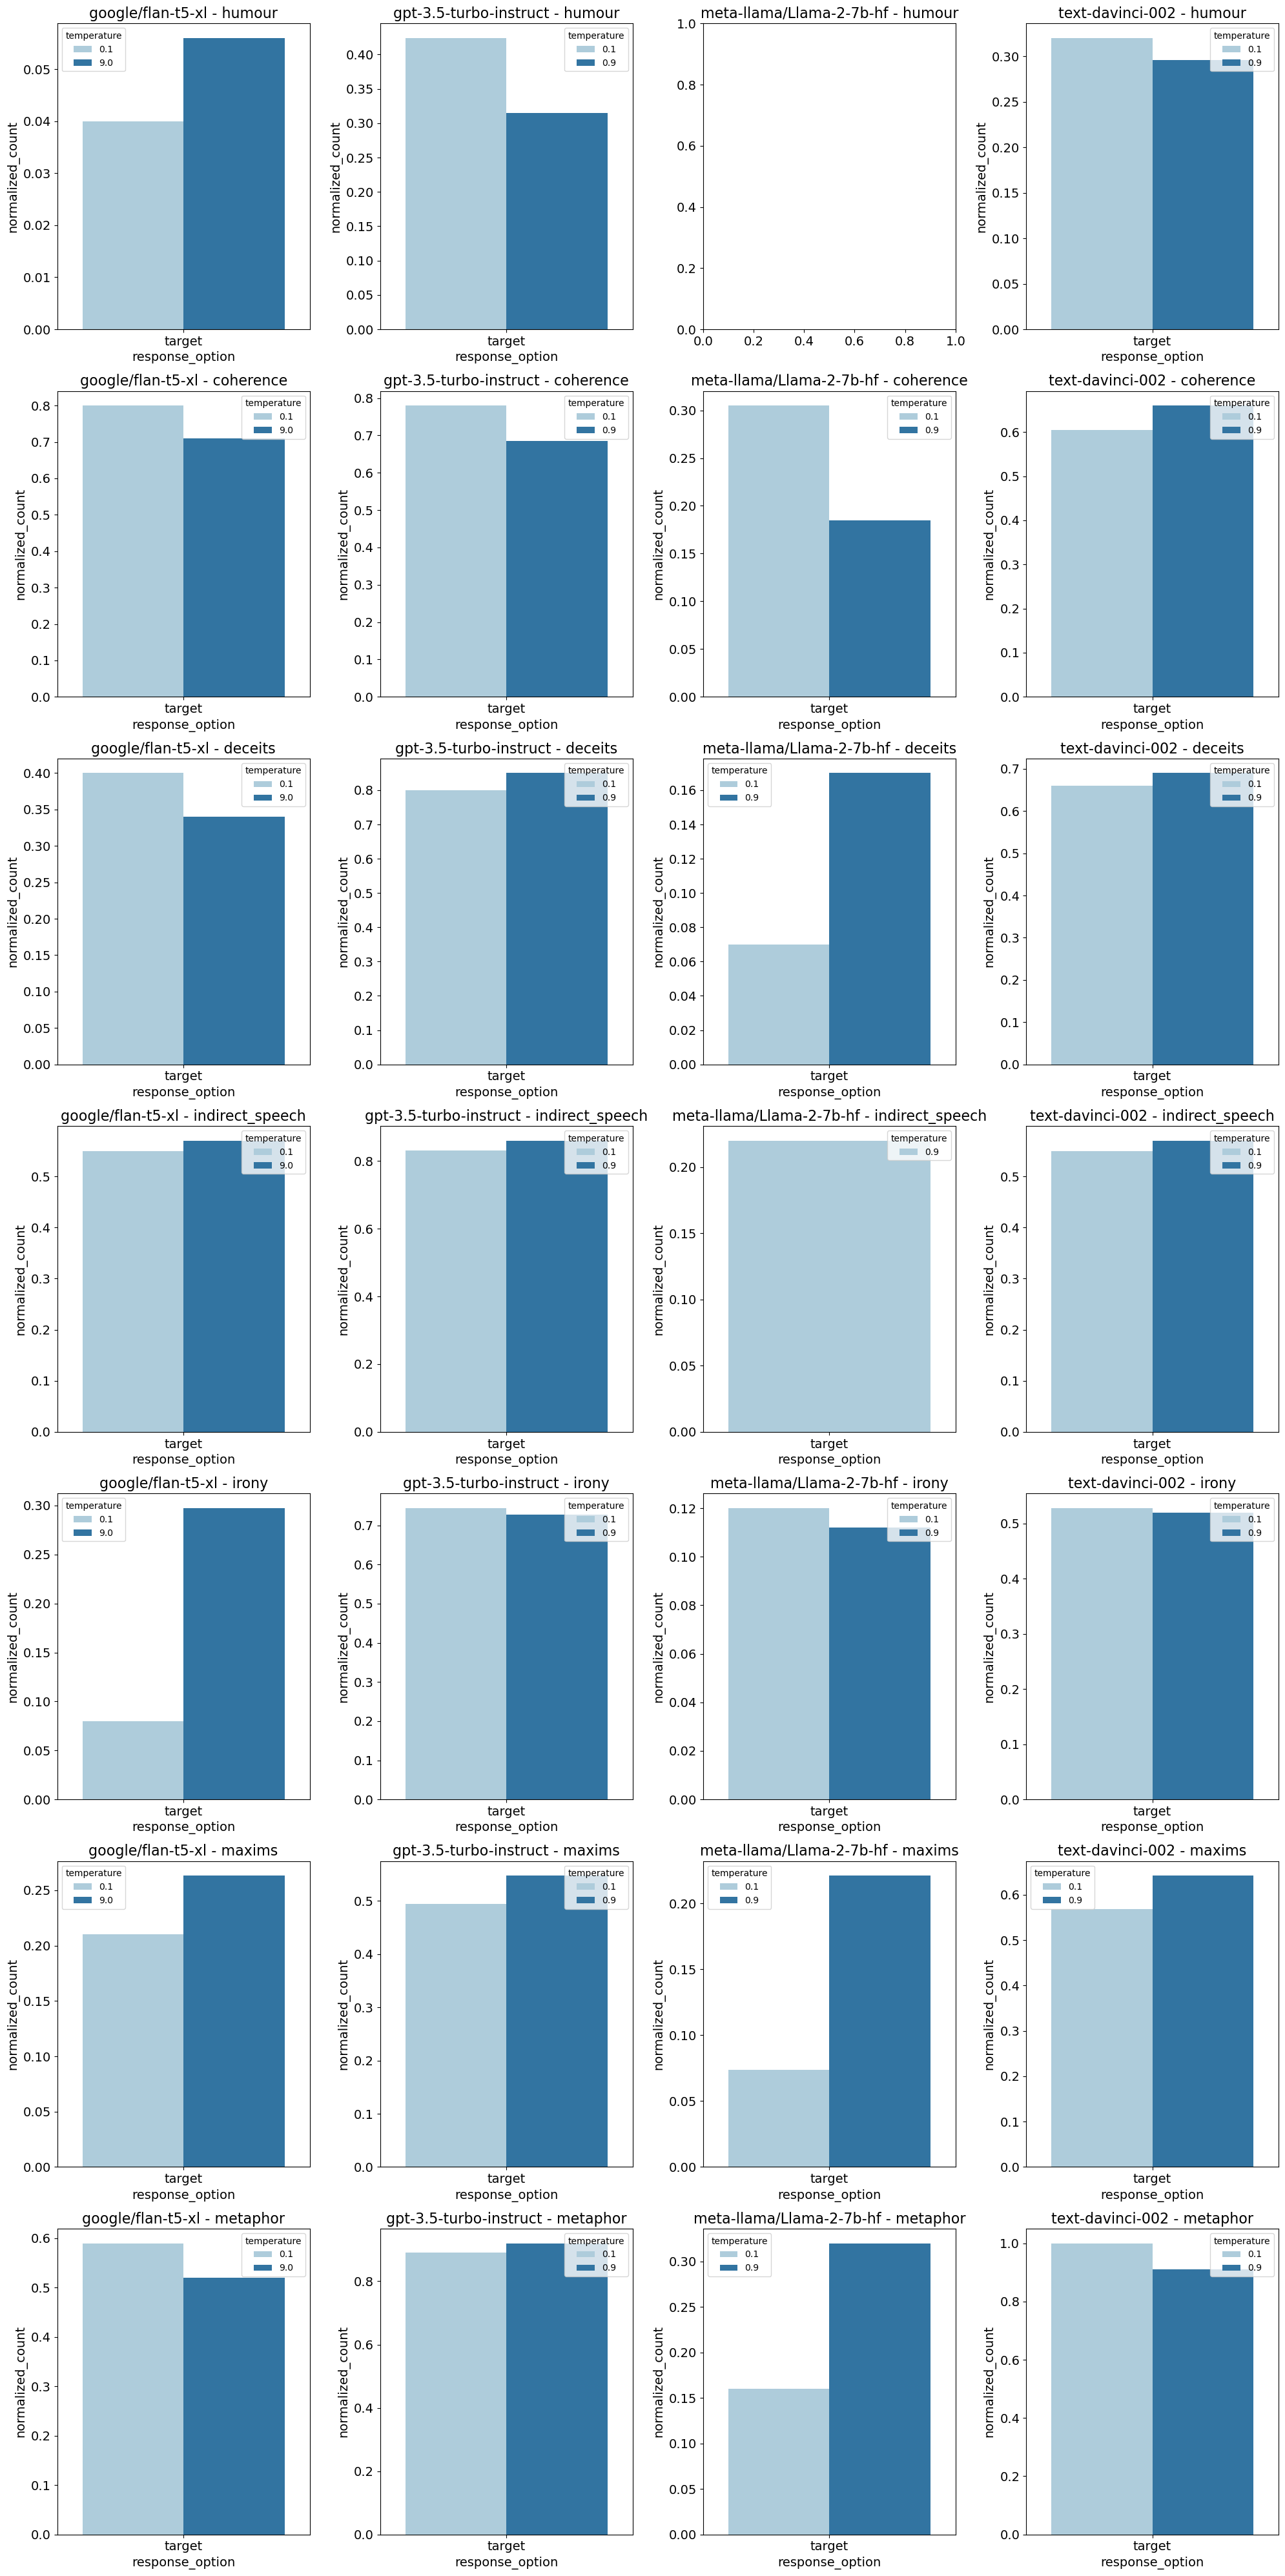

In [61]:
# Subset to only target responses
non_zero_melted_data_target = non_zero_melted_data[non_zero_melted_data['response_option'] == "target"]

# Set up the grid layout for the subplots
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=False)

# Iterate over each model and phenomenon to create individual subplots
for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset_data = non_zero_melted_data_target[(non_zero_melted_data_target['model_name'] == model) & 
                                           (non_zero_melted_data_target['phenomenon'] == phenomenon)]
        sns.barplot(data=subset_data, x='response_option', y='normalized_count', ax=ax, hue='temperature', palette='Paired')
        ax.set_title(f"{model} - {phenomenon}")
        #ax.tick_params(axis="x", rotation=90)

        # Set title with larger font size
        ax.set_title(f"{model} - {phenomenon}", fontsize=16)
        
        # Increase tick label size
        ax.tick_params(axis="x", rotation=0, labelsize=14)
        ax.tick_params(axis="y", labelsize=14)
        
        # Increase axis label size
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)

plt.tight_layout()
plt.show()

In [62]:
# Define the path to save the plot as PDF
save_path = "plots/free_prop.target_against_temperature_by_model_phenomenon.pdf"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the plot to the specified path
fig.savefig(save_path, bbox_inches='tight')

save_path


'plots/free_prop.target_against_temperature_by_model_phenomenon.pdf'

## Plot proportion of target against others grouped by phenomenon and model

Use df_annotated_no_temperature for further plotting.

In [63]:
# Subset the data with temperature == 0.1
df_annotated_no_temperature = df_annotated[df_annotated['temperature'] == 0.1]

# Group by 'phenomenon', 'model_name', and 'response_option', then compute the counts
association_counts_model_phenomenon = df_annotated_no_temperature.groupby(['phenomenon', 'model_name', 'response_option']).size().reset_index(name='count')

# Compute the total count for each combination of 'phenomenon' and 'model_name'
total_counts_model_phenomenon = df_annotated_no_temperature.groupby(['phenomenon', 'model_name']).size().reset_index(name='total_count')

# Merge the dataframes on 'phenomenon' and 'model_name'
normalized_counts = pd.merge(association_counts_model_phenomenon, total_counts_model_phenomenon, on=['phenomenon', 'model_name'])

# Compute the normalized count
normalized_counts['normalized_count'] = normalized_counts['count'] / normalized_counts['total_count']

# Pivot the table for better visualization
normalized_counts_pivot = normalized_counts.pivot_table(index=['phenomenon', 'model_name'], columns='response_option', values='normalized_count').fillna(0)

normalized_counts_pivot  # Displaying the first 10 rows for brevity

# Reset index for the pivot table for plotting
normalized_counts_pivot_reset = normalized_counts_pivot.reset_index()

# Melt the DataFrame to have 'response_option' and 'normalized_count' as separate columns
melted_data = normalized_counts_pivot_reset.melt(id_vars=['phenomenon', 'model_name'], 
                                                 value_vars=normalized_counts_pivot.columns, 
                                                 var_name='response_option', 
                                                 value_name='normalized_count')

# Filter out rows where normalized_count is zero to only plot non-zero responses
non_zero_melted_data = melted_data[melted_data['normalized_count'] > 0]

## Extract unique models and phenomena
unique_models = non_zero_melted_data['model_name'].unique()
unique_phenomena = non_zero_melted_data['phenomenon'].unique()

# Use a custom color palette to highlight 'target' response_option
palette = {response: 'gray' if response != 'target' else 'red' for response in non_zero_melted_data['response_option'].unique()}


/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_15400/2949730459.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  association_counts_model_phenomenon = df_annotated_no_temperature.groupby(['phenomenon', 'model_name', 'response_option']).size().reset_index(name='count')


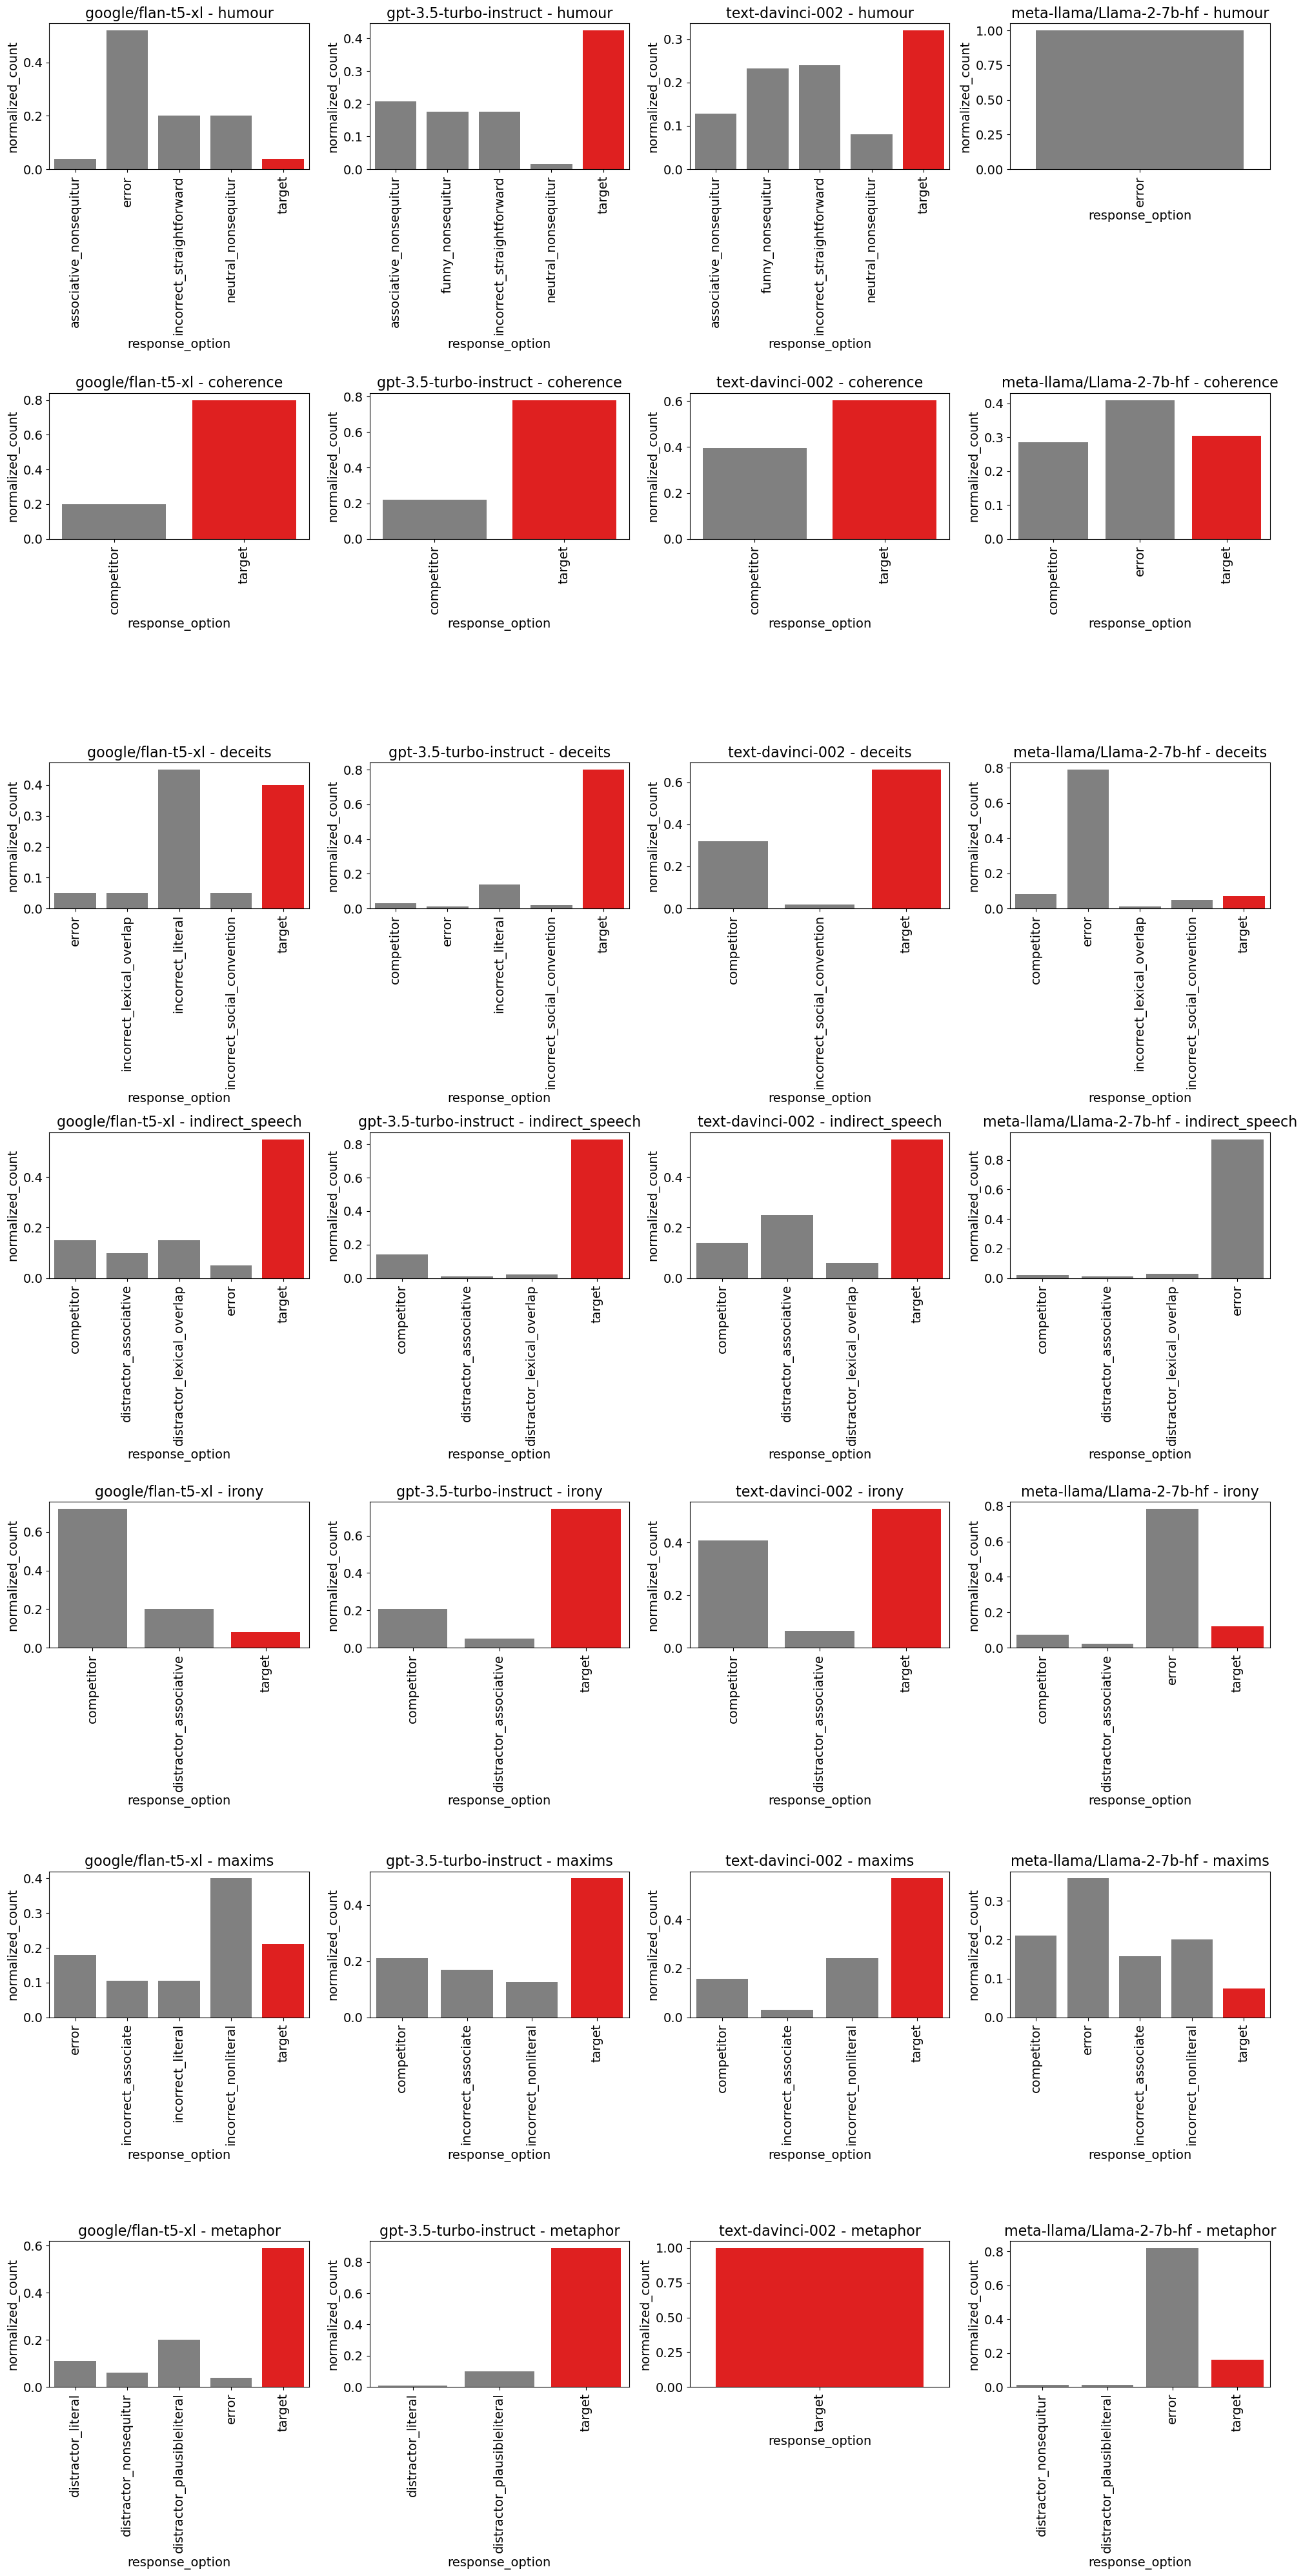

In [64]:
# Set up the grid layout for the subplots
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=False)

# Iterate over each model and phenomenon to create individual subplots
for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset_data = non_zero_melted_data[(non_zero_melted_data['model_name'] == model) & 
                                           (non_zero_melted_data['phenomenon'] == phenomenon)]
        sns.barplot(data=subset_data, x='response_option', y='normalized_count', ax=ax, palette=palette, hue='response_option')
        ax.set_title(f"{model} - {phenomenon}")
        ax.tick_params(axis="x", rotation=90)

        # Set title with larger font size
        ax.set_title(f"{model} - {phenomenon}", fontsize=16)
        
        # Increase tick label size
        ax.tick_params(axis="x", rotation=90, labelsize=14)
        ax.tick_params(axis="y", labelsize=14)
        
        # Increase axis label size
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)

plt.tight_layout()
plt.show()



In [65]:
# Define the path to save the plot as PDF
save_path = "plots/free_prop.target_against_options_by_model_phenomenon.pdf"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the plot to the specified path
fig.savefig(save_path, bbox_inches='tight')

save_path


'plots/free_prop.target_against_options_by_model_phenomenon.pdf'

## Plot proportion of target against others grouped by phenomenon and model

Use df_annotated_no_temperature for further plotting.

In [66]:
# Re-encode the option_names column to be more readable
df_annotated_no_temperature_binary = df_annotated_no_temperature.copy()
df_annotated_no_temperature_binary.loc[:,'response_option'] = np.where(df_annotated_no_temperature_binary['response_option'] == 'target', 1, 0)

# Use a custom color palette to highlight 'target' response_option
palette = {response: 'gray' if response != 1 else 'red' for response in df_annotated_no_temperature_binary['response_option'].unique()}

# Calculating the proportion of each chosen_option for each model and phenomenon combination
proportion_data = df_annotated_no_temperature_binary.groupby(['model_name', 'phenomenon', 'response_option']).size().reset_index(name='counts')

# Calculating the proportion of each chosen_option for each model and phenomenon combination again
total_counts = proportion_data.groupby(['model_name', 'phenomenon'])['counts'].transform('sum')
proportion_data['proportion'] = proportion_data['counts'] / total_counts

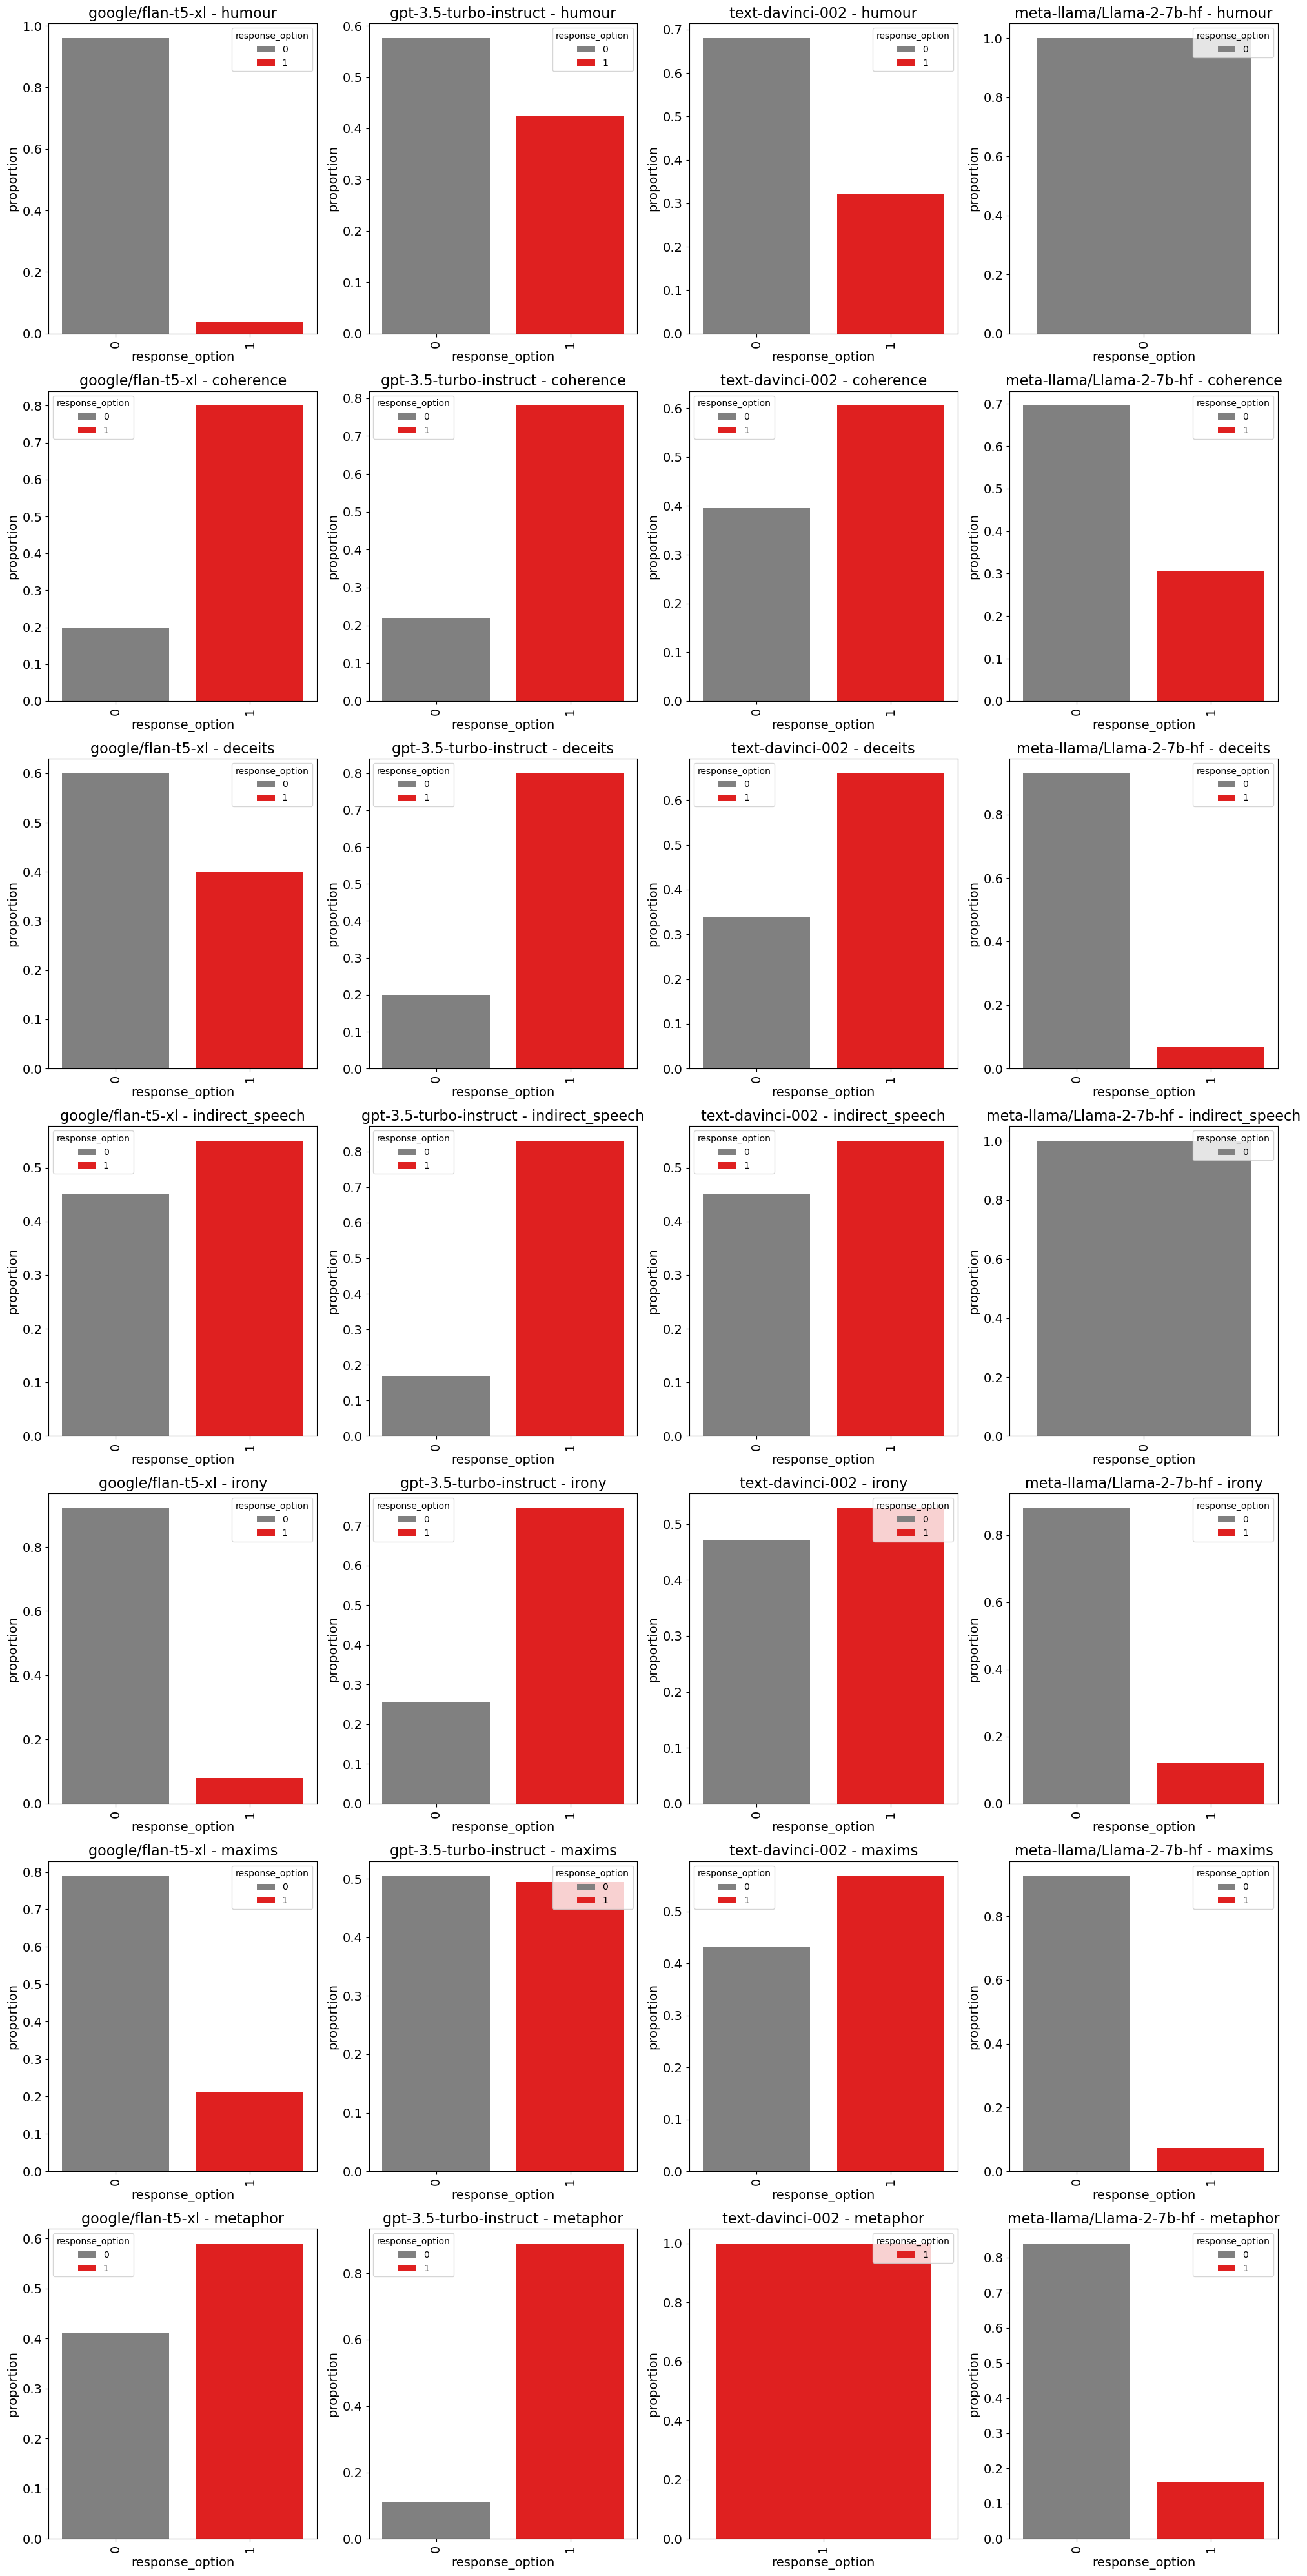

In [67]:

# Set up the grid layout for the subplots
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=False)

# Iterate over each model and phenomenon to create individual subplots
for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset_data = proportion_data[(proportion_data['model_name'] == model) & 
                                           (proportion_data['phenomenon'] == phenomenon)]
        sns.barplot(data=subset_data, x='response_option', y='proportion', ax=ax, palette=palette, hue='response_option')
        ax.set_title(f"{model} - {phenomenon}")
        ax.tick_params(axis="x", rotation=90)

        # Set title with larger font size
        ax.set_title(f"{model} - {phenomenon}", fontsize=16)
        
        # Increase tick label size
        ax.tick_params(axis="x", rotation=90, labelsize=14)
        ax.tick_params(axis="y", labelsize=14)
        
        # Increase axis label size
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)

plt.tight_layout()
plt.show()




In [68]:
# Define the path to save the plot as PDF
save_path = "plots/free_prop.target_against_others_by_model_phenomenon.pdf"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the plot to the specified path
fig.savefig(save_path, bbox_inches='tight')

save_path


'plots/free_prop.target_against_others_by_model_phenomenon.pdf'

## Export CSV for further analysis

In [69]:
# Take a look
df_annotated_no_temperature_binary

,model_name,temperature,phenomenon,decoding_scheme,question,seed,item_id,prompt,response,response_option,...,distractor_literal,distractor_nonsequitut,incorrect_straightforward,associative_nonsequitur,funny_nonsequitur,neutral_nonsequitur,incorrect_lexical_overlap,incorrect_social_convention,annotation_tsvilodub,annotation_wang
184,meta-llama/Llama-2-7b-hf,0.1,humour,greedy,NaN,3,1,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,meta-llama/Llama-2-7b-hf,0.1,humour,greedy,NaN,3,2,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,meta-llama/Llama-2-7b-hf,0.1,humour,greedy,NaN,3,3,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,meta-llama/Llama-2-7b-hf,0.1,humour,greedy,NaN,3,4,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,meta-llama/Llama-2-7b-hf,0.1,humour,greedy,NaN,3,5,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6741,google/flan-t5-xl,0.1,irony,greedy,NaN,1,21,You will read a short story that describes an ...,He was impressed with Tracy's performance.,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,competitor,NaN
6742,google/flan-t5-xl,0.1,irony,greedy,NaN,1,22,You will read a short story that describes an ...,He was disappointed in him.,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,competitor,NaN
6743,google/flan-t5-xl,0.1,irony,greedy,NaN,1,23,You will read a short story that describes an ...,He was proud of the gardener.,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,competitor,NaN
6744,google/flan-t5-xl,0.1,irony,greedy,NaN,1,24,You will read a short story that describes an ...,He was proud of her.,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,competitor,NaN


In [70]:
# Add a column to indicate metrics
df_annotated_no_temperature_binary['metric'] = 'free'

In [71]:
print(df_annotated_no_temperature_binary.groupby(['response_option', 'phenomenon', 'model_name', 'item_id', 'seed', 'metric']).size().reset_index(name='counts'))
free_wide_out = df_annotated_no_temperature_binary[['response_option', 'phenomenon', 'model_name', 'item_id', 'seed','metric']].copy().reset_index(drop=True)
print(free_wide_out)

      response_option phenomenon         model_name  item_id  seed metric  \
0                   0  coherence  google/flan-t5-xl        3     1   free   
1                   0  coherence  google/flan-t5-xl        3     2   free   
2                   0  coherence  google/flan-t5-xl        3     3   free   
3                   0  coherence  google/flan-t5-xl        3     4   free   
4                   0  coherence  google/flan-t5-xl        4     1   free   
...               ...        ...                ...      ...   ...    ...   
3206                1   metaphor   text-davinci-002       20     0   free   
3207                1   metaphor   text-davinci-002       20     1   free   
3208                1   metaphor   text-davinci-002       20     2   free   
3209                1   metaphor   text-davinci-002       20     3   free   
3210                1   metaphor   text-davinci-002       20     4   free   

      counts  
0          2  
1          1  
2          1  
3          1  


In [72]:
# Group by 'phenomenon', 'model_name', 'temperature', and 'response_option', then compute the counts
association_counts_model_phenomenon = free_wide_out.groupby(['phenomenon', 'model_name', 'response_option', 'metric']).size().reset_index(name = 'count')

# Compute the total count for each combination of 'phenomenon' and 'model_name'
total_counts_model_phenomenon = free_wide_out.groupby(['phenomenon', 'model_name', 'metric']).size().reset_index(name='total_count')

# Merge the dataframes on 'phenomenon' and 'model_name'
normalized_counts = pd.merge(association_counts_model_phenomenon, total_counts_model_phenomenon, on=['phenomenon', 'model_name', 'metric'])

# Compute the normalized count
normalized_counts['dependent_variable'] = normalized_counts['count'] / normalized_counts['total_count']

#print(normalized_counts)

free_summary_out = normalized_counts[normalized_counts['response_option'] == 1].copy()

free_summary_out.drop(columns=['count', 'total_count', 'response_option'], inplace=True)

print(free_summary_out) 

         phenomenon                model_name metric  dependent_variable
1         coherence         google/flan-t5-xl   free            0.800000
3         coherence    gpt-3.5-turbo-instruct   free            0.780000
5         coherence  meta-llama/Llama-2-7b-hf   free            0.305000
7         coherence          text-davinci-002   free            0.605000
9           deceits         google/flan-t5-xl   free            0.400000
11          deceits    gpt-3.5-turbo-instruct   free            0.800000
13          deceits  meta-llama/Llama-2-7b-hf   free            0.070000
15          deceits          text-davinci-002   free            0.660000
17           humour         google/flan-t5-xl   free            0.040000
19           humour    gpt-3.5-turbo-instruct   free            0.424000
22           humour          text-davinci-002   free            0.320000
24  indirect_speech         google/flan-t5-xl   free            0.550000
26  indirect_speech    gpt-3.5-turbo-instruct   fre

In [73]:
# Save csv file
wide_out_path = "processed_data/free_accuracy_wide.csv"
summary_out_path = "processed_data/free_accuracy_summary.csv"
# Ensure the directory exists
os.makedirs(os.path.dirname(wide_out_path), exist_ok=True)
os.makedirs(os.path.dirname(summary_out_path), exist_ok=True)

# Save the csv to the specified path
free_wide_out.to_csv(wide_out_path, index=False)
free_summary_out.to_csv(summary_out_path, index=False)

## Analysis of combining human data together

In [74]:
# # Import human data
# # Define the path to the 'free' subfolder
# human_folder_path = "../human_data"

# # Recursively list all csv files in the 'free' folder
# csv_files = []
# for root, dirs, files in os.walk(human_folder_path):
#     for file in files:
#         if file.endswith(".csv"):
#             csv_files.append(os.path.join(root, file))

# # Concatenate all annotated csv files into a single dataframe
# df_human = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# PHENOMENA_LLM_LINK = {
#     "HV": "humour", 
#     "IV": "irony",
#     "ISV": "indirect_speech",
#     "DV": "deceits",
#     "CIV": "coherence",
#     "MV": "maxims",
#     "MPV": "metaphor"
# }

# # Remap the "Task" column
# df_human['Task'] = df_human['Task'].map(PHENOMENA_LLM_LINK)

# # Display the unique values
# print(df_human['Task'].unique())
      
# # Return the first few rows of the concatenated dataframe and the number of non-annotated files
# df_human.head(), len(df_human)


In [75]:
# # Normalize df_human
# # Group by 'phenomenon', 'model_name', and 'response_option', then compute the counts
# aggregated_counts_human = df_human.groupby(['Task', 'Correct']).size().reset_index(name='count')

# # Compute the total count for each combination of 'Task' and 'itemNum'
# total_counts_human = df_human.groupby(['Task']).size().reset_index(name='total_count')

# # Merge the dataframes on 'phenomenon' and 'model_name'
# normalized_counts_human = pd.merge(aggregated_counts_human, total_counts_human, on=['Task'])

# # Compute the normalized count
# normalized_counts_human['normalized_count'] = normalized_counts_human['count'] / normalized_counts_human['total_count']

# # Pivot the table for better visualization
# normalized_counts_human_pivot = normalized_counts_human.pivot_table(index=['Task'], columns='Correct', values='normalized_count').fillna(0)

# normalized_counts_human_pivot  # Displaying the first 10 rows for brevity


In [76]:
# # Reset index for the pivot table for plotting
# normalized_counts_pivot_reset = normalized_counts_human_pivot.reset_index()

# # Melt the DataFrame to have 'response_option' and 'normalized_count' as separate columns
# melted_data = normalized_counts_pivot_reset.melt(id_vars=['Task'], 
#                                                  value_vars=normalized_counts_human_pivot.columns, 
#                                                  var_name='Correct', 
#                                                  value_name='normalized_count')

# # Filter out rows where normalized_count is zero to only plot non-zero responses
# non_zero_melted_human_data = melted_data[(melted_data['normalized_count'] > 0) & (melted_data['Correct'] == True)]



# # Rename the columns of human data
# human_data_cleaned = non_zero_melted_human_data.copy()

# human_data_cleaned.rename(columns={
#     "Task": "phenomenon",
#     "normalized_count": "dependent_variable"
# }, inplace=True)
# # Add two new columns with specified values
# human_data_cleaned.loc[:,'model_name'] = 'human'
# human_data_cleaned.loc[:,'metric'] = 'forced_choice'

# # Drop column "Correct"
# human_data_cleaned.drop(columns=['Correct'], inplace=True)
# human_data_cleaned.reset_index(drop=True, inplace=True)

# print(human_data_cleaned)


# # Rename the columns of model_data
# model_data_cleaned = non_zero_melted_data_target.copy()

# model_data_cleaned.rename(columns={
#     "normalized_count": "dependent_variable"
# }, inplace=True)

# # Add one new column with specified values
# model_data_cleaned.loc[:,'metric'] = 'free_production'

# # Subset data by temperature
# model_data_cleaned = model_data_cleaned[model_data_cleaned['temperature'] == 0.1]
# model_data_cleaned.drop(columns=['temperature', 'response_option'], inplace=True)


# model_data_cleaned.reset_index(drop=True, inplace=True)
# model_data_cleaned


In [77]:
# merged_df = pd.merge(human_data_cleaned, model_data_cleaned, how='outer')
# print(merged_df)
# # Save the csv to the specified path
# merged_df.to_csv('processed_data/free_accuracy_summary.csv', index=False)

In [78]:
# g = sns.catplot(data=merged_df, 
#                 x='phenomenon', 
#                 y='dependent_variable', 
#                 hue='model_name', 
#                 col='metric', 
#                 kind='bar', 
#                 height=4, 
#                 aspect=1)

# g.set_axis_labels("Phenomenon", "Dependent Variable Value")
# g.set_titles("Metrics: {col_name}")
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()


In [79]:
# # Define the path to save the plot as PDF
# save_path = "plots/corecctness_metrics_model_task.pdf"

# # Ensure the directory exists
# os.makedirs(os.path.dirname(save_path), exist_ok=True)

# # Save the plot to the specified path
# g.savefig(save_path, bbox_inches='tight')

# save_path
